# Forecast mobility 

Forecast the mobility indices forward

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import date, timedelta, datetime

plt.style.use('seaborn-poster')
value_vars=['retail_and_recreation_percent_change_from_baseline',
                            'grocery_and_pharmacy_percent_change_from_baseline',
                            'parks_percent_change_from_baseline',
                            'transit_stations_percent_change_from_baseline',
                            'workplaces_percent_change_from_baseline',
                            'residential_percent_change_from_baseline']
mov_values = [ val[:-29]+'_7days' for val in value_vars]
states_initials ={
    'Western Australia':'WA',
    'South Australia':'SA',
    'Tasmania':'TAS',
    'Queensland':'QLD',
    'New South Wales':'NSW',
    'Victoria':'VIC',
    'Australian Capital Territory':'ACT',
    'Northern Territory':'NT'
}
def read_in_google(Aus_only=True,local=False,moving=False):
    """
    Read in the Google data set
    """
    if local:
        if type(local)==str:
            df = pd.read_csv(local,parse_dates=['date'])
        elif type(local)==bool:
            local = '../data/Global_Mobility_Report.csv'
            df = pd.read_csv(local,parse_dates=['date'])
    else:
        df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv',parse_dates=['date'])
    
    
    if Aus_only:
        df = df.loc[df.country_region_code=='AU']
        #Change state column to state initials
        df['state'] = df.sub_region_1.map(lambda x: states_initials[x] if not pd.isna(x) else 'AUS' )

    if moving:
        # generate moving average columns in reverse
        df = df.sort_values(by='date')
        mov_values = []
        for val in value_vars:
            mov_values.append(val[:-29]+'_7days')
            df[mov_values[-1]]=df.groupby(['state'])[val].transform(lambda x: x[::-1].rolling(7,1).mean()[::-1]) #minimum number of 1
    print("Last Google date is "+ str(df.date.values[-1]) )
    return df

def read_in_posterior(date='2020-07-01'):
    """
    read in samples from posterior from inference
    """
    df = pd.read_hdf("../data/soc_mob_posterior"+date+".h5", key='samples')
    
    return df

In [2]:
df_google = read_in_google(Aus_only=True,moving=True,local=True)
states = ['NSW','QLD','SA','VIC','TAS','WA','ACT','NT','AUS']
plot_states = states.copy()
plot_states.remove('AUS')
df_samples = read_in_posterior()

df_google.tail()

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Last Google date is 2020-06-23T00:00:00.000000000


,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days,residential_7days
7403,AU,Australia,Northern Territory,NaN,AU-NT,NaN,2020-06-23,2.0,8.0,8.0,-25.0,8.0,2.0,NT,2.0,8.0,8.0,-25.0,8.0,2.0
7793,AU,Australia,Tasmania,NaN,AU-TAS,NaN,2020-06-23,-29.0,-13.0,-63.0,-47.0,-10.0,9.0,TAS,-29.0,-13.0,-63.0,-47.0,-10.0,9.0
7013,AU,Australia,NaN,NaN,NaN,NaN,2020-06-23,-17.0,-1.0,-22.0,-41.0,-18.0,10.0,AUS,-17.0,-1.0,-22.0,-41.0,-18.0,10.0
7143,AU,Australia,Australian Capital Territory,NaN,AU-ACT,NaN,2020-06-23,-20.0,-6.0,-17.0,-40.0,-19.0,11.0,ACT,-20.0,-6.0,-17.0,-40.0,-19.0,11.0
8053,AU,Australia,Western Australia,NaN,AU-WA,NaN,2020-06-23,-8.0,5.0,-23.0,-36.0,-5.0,6.0,WA,-8.0,5.0,-23.0,-36.0,-5.0,6.0


In [3]:
six_weeks = pd.to_datetime(df_google.date.values[-1]) + timedelta(
    days=pd.to_datetime(
        datetime.today()).dayofyear -
    pd.to_datetime(df_google.date.values[-1]).dayofyear + 70)

days_from_March = six_weeks.dayofyear -pd.to_datetime('2020-03-01').dayofyear

days_from_March

192

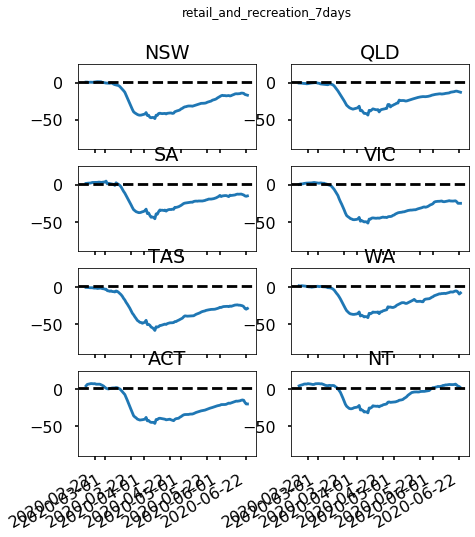

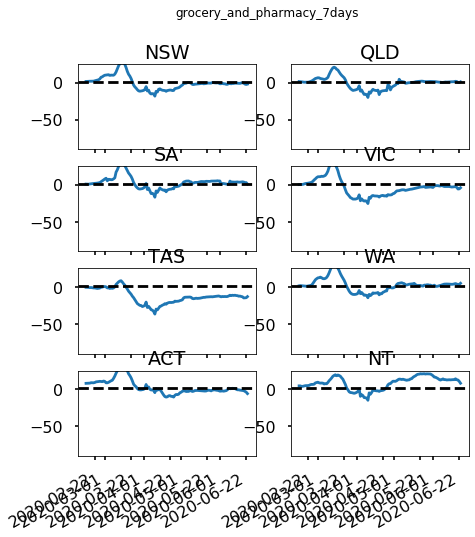

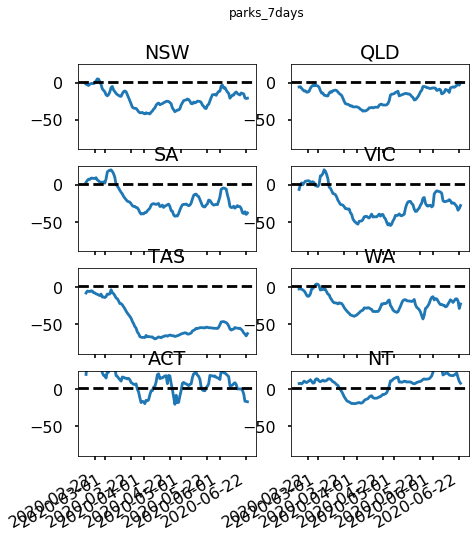

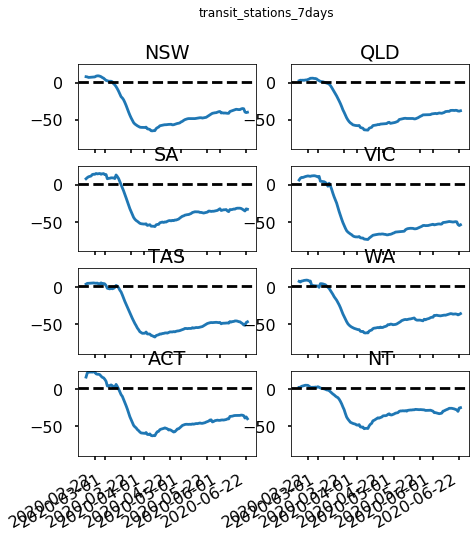

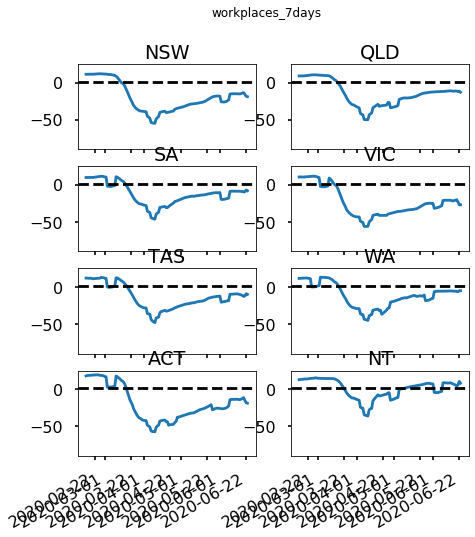

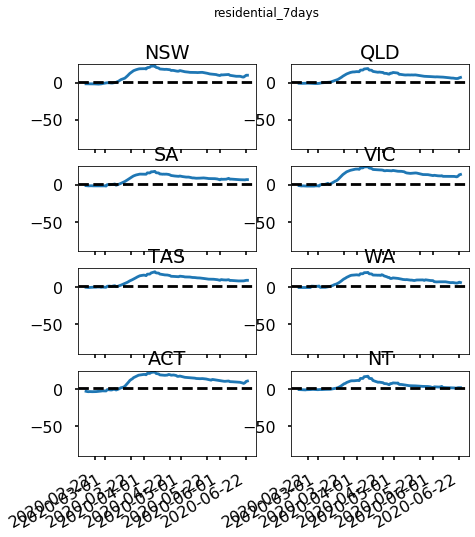

In [4]:
predictors = mov_values.copy()
predictors.remove('residential_7days')
for var in mov_values:
    fig, axs = plt.subplots(figsize=(7,8),nrows=4, ncols=2, sharex=True)

    for i,state in enumerate(plot_states):
        rownum = int(i/2.)
        colnum = np.mod(i,2)


        Rmed = df_google[df_google['state'] == state][var]
        dates = df_google[df_google['state'] == state]['date']
        axs[rownum,colnum].plot(dates,Rmed)
        axs[rownum,colnum].axhline(1,ls = '--', c = 'k')
        axs[rownum,colnum].set_ylim(-90,25)
        axs[rownum,colnum].set_title(state)

    fig.suptitle(var)
    fig.autofmt_xdate()

Forecast ends at 190 days after 1st March
Final date is 2020-09-07 00:00:00


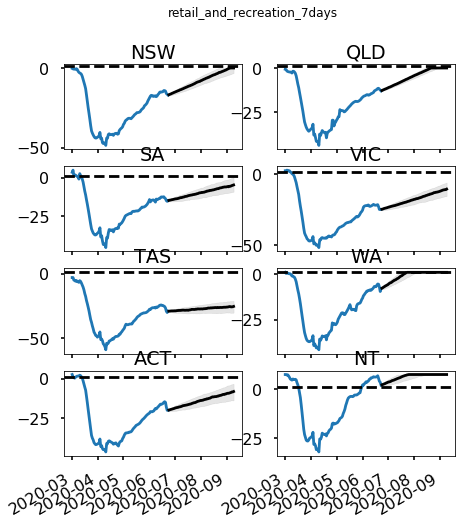

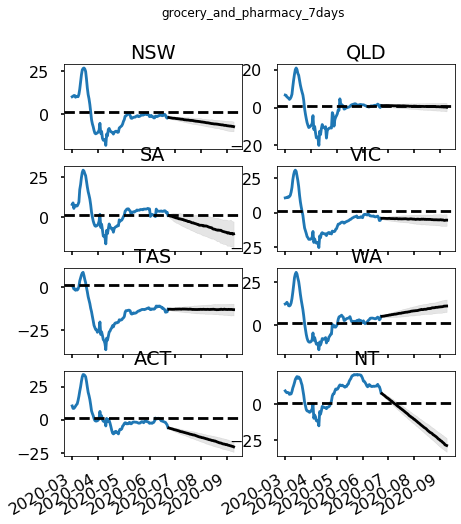

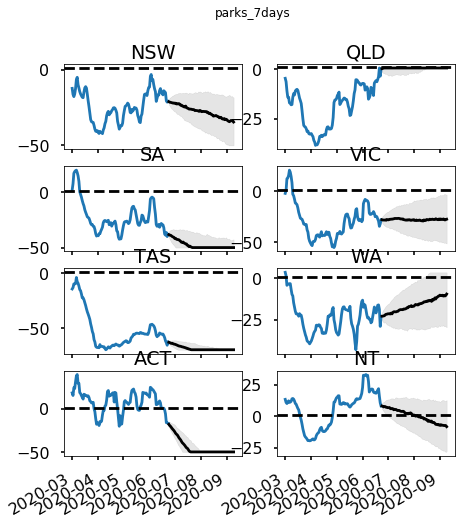

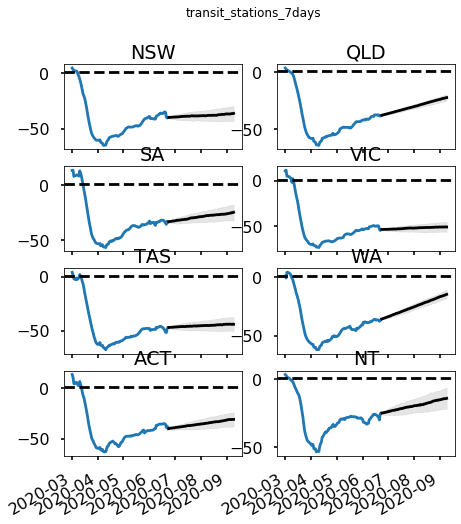

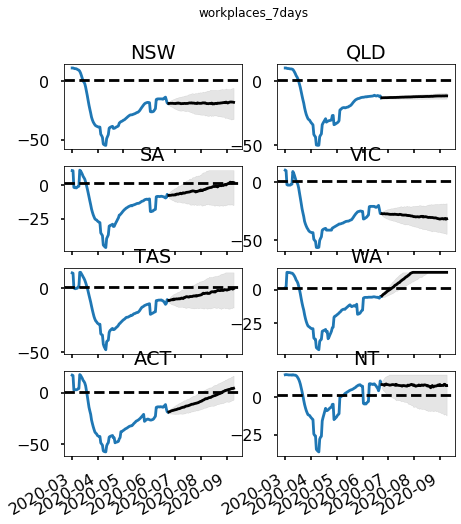

In [5]:
#forecast time parameters
n_training =28

n_forecast = 70 + (pd.to_datetime(datetime.today()) - df_google.date.values[-1]).days
recov_factor = 1
#cap = 0 #10?
training_start_date = datetime(2020,3,1,0,0)
print("Forecast ends at {} days after 1st March".format(
    pd.to_datetime('2020-06-29').dayofyear + 70 - pd.to_datetime(training_start_date).dayofyear)
     )
print("Final date is {}".format(pd.to_datetime('2020-06-29') + timedelta(days=70)))
df_google = df_google.loc[df_google.date>= training_start_date]
outdata = {'date': [],
           'type': [],
           'state': [],
            'mean': [],
            'std' : [],
          }

for var in predictors:
    fig, axs = plt.subplots(figsize=(7,8),nrows=4, ncols=2, sharex=True)

    for i,state in enumerate(states):
        rownum = int(i/2.)
        colnum = np.mod(i,2)

        Rmed = df_google[df_google['state'] == state][var]
        dates = df_google[df_google['state'] == state]['date']
        
        #cap min and max at historical or (-50,0)
        minRmed = min(-50,min(Rmed))
        maxRmed = max(0,max(Rmed))
        
        
        R_diffs = np.diff(Rmed[-n_training:])

    #     forecast_start = dates.index[dates == datetime(2020,4,1,0,0)].tolist()[0]
    #     R_diffs = np.diff(Rmed.loc[forecast_start:])

        mu, std = norm.fit(R_diffs)
        sims = np.minimum(maxRmed,Rmed.tolist()[-1] + np.cumsum(recov_factor*np.random.normal(mu,
                                                              std,
                                                              size=(1000,n_forecast)),
                                             axis=1))
        sims = np.maximum(minRmed, sims)
        #dates of forecast to enter
        dd = [dates.tolist()[-1] + timedelta(days=x) for x in range(1,n_forecast+1)]

    #     print(state)

        sims_med = np.median(sims,axis=0)
        sims_q25 = np.percentile(sims,25,axis=0)
        sims_q75 = np.percentile(sims,75,axis=0)

        if state in plot_states:
            axs[rownum,colnum].plot(dates,Rmed)
            axs[rownum,colnum].plot(dd,sims_med,'k')
            axs[rownum,colnum].fill_between(dd, sims_q25, sims_q75, color='k',alpha = 0.1)
            axs[rownum,colnum].set_title(state)
            axs[rownum,colnum].axhline(1,ls = '--', c = 'k')

        #Record data
        outdata['date'].extend([d.strftime('%Y-%m-%d') for d in dd])
        outdata['type'].extend([var]*len(dd))
        outdata['state'].extend([state]*len(dd))
        outdata['mean'].extend(np.mean(sims,axis=0))
        outdata['std'].extend(np.std(sims,axis=0))


    fig.suptitle(var)
    fig.autofmt_xdate()
#plt.savefig('../figs/Reff_forecast_rw_training' + str(n_training) + '.pdf')

In [6]:
df_out = pd.DataFrame.from_dict(outdata)
df_forecast = pd.pivot_table(df_out, columns=['type'],index=['date','state'],values=['mean'])
df_std = pd.pivot_table(df_out, columns=['type'],index=['date','state'],values=['std'])


#align with google order in columns
df_forecast = df_forecast.reindex([('mean',val) for val in predictors],axis=1)
df_std = df_std.reindex([('std',val) for val in predictors],axis=1) 
df_forecast.columns = predictors #remove the tuple name of columns
df_std.columns = predictors

df_forecast = df_forecast.reset_index() 
df_std = df_std.reset_index()
df_forecast.date = pd.to_datetime(df_forecast.date)
df_std.date = pd.to_datetime(df_std.date)

In [7]:
display(df_std.tail()) #forecast up to 
df_forecast.tail()

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days
697,2020-09-09,QLD,0.447973,3.188469,6.053883,4.044345,3.295491
698,2020-09-09,SA,6.257995,12.343686,14.096045,10.629463,16.366652
699,2020-09-09,TAS,6.816884,5.045735,5.496106,9.415489,16.867813
700,2020-09-09,VIC,6.704434,6.451765,26.191289,8.040335,17.322909
701,2020-09-09,WA,0.465336,5.531098,18.545317,5.472900,2.802719


,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days
697,2020-09-09,QLD,-0.094047,0.233306,-1.471671,-22.293377,-11.418752
698,2020-09-09,SA,-4.787945,-10.688328,-43.097357,-24.653171,-3.748703
699,2020-09-09,TAS,-25.525372,-13.184407,-67.992501,-43.676292,-4.473594
700,2020-09-09,VIC,-10.915710,-5.387648,-24.007320,-51.009819,-30.722732
701,2020-09-09,WA,0.951316,11.324065,-14.514037,-14.336617,12.467542


In [8]:
df_R = df_google[['date','state']+mov_values] 
df_R = pd.concat([df_R,df_forecast],ignore_index=True,sort=False)
df_R['policy'] = (df_R.date>='2020-03-16').astype('int8')

df_R

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days,residential_7days,policy
0,2020-03-01,VIC,2.142857,10.857143,-2.285714,10.571429,10.285714,-1.428571,0
1,2020-03-01,TAS,-3.000000,0.571429,-14.285714,4.142857,11.857143,-0.285714,0
2,2020-03-01,NSW,-0.285714,10.000000,-12.428571,4.571429,11.571429,-0.714286,0
3,2020-03-01,NT,7.428571,9.428571,13.285714,3.285714,14.571429,-0.714286,0
4,2020-03-01,ACT,2.571429,10.428571,18.000000,13.285714,17.142857,-2.285714,0
...,...,...,...,...,...,...,...,...,...
1732,2020-09-09,QLD,-0.094047,0.233306,-1.471671,-22.293377,-11.418752,NaN,1
1733,2020-09-09,SA,-4.787945,-10.688328,-43.097357,-24.653171,-3.748703,NaN,1
1734,2020-09-09,TAS,-25.525372,-13.184407,-67.992501,-43.676292,-4.473594,NaN,1
1735,2020-09-09,VIC,-10.915710,-5.387648,-24.007320,-51.009819,-30.722732,NaN,1


In [9]:
#generate posterior estimates of each state
from scipy.special import expit
df_R = df_R.sort_values('date')
n_samples = 100
samples = df_samples.sample(n_samples) #test on sample of 2
forecast_type = ['R_L','R_L0']
state_Rs = {
    'state':[],
    'date':[],
    'type':[],
    'median':[],
    'lower':[],
    'upper':[],
    'bottom':[],
    'top':[],
    'mean':[],
    'std':[],
}
ban = '2020-03-16'
new_pol = '2020-06-01' #VIC and NSW allow gatherings of up to 20 people, other jurisdictions allow for 
typ_state_R={}
mob_forecast_date = df_forecast.date.min()
mob_samples = 100
print("forecast mobility from "+str(mob_forecast_date))
for typ in forecast_type:
    state_R={}
    for state in states:
    #sort df_R by date so that rows are dates

        #rows are dates, columns are predictors
        df_state = df_R.loc[df_R.state==state]
        dd = df_state.date
        post_values = samples[predictors].values.T
        
        for n in range(mob_samples):
            #add gaussian noise to predictors after forecast
            df_state.loc[df_state.date>=mob_forecast_date,predictors] = df_state.loc[
                df_state.date>=mob_forecast_date,predictors] + np.random.normal(
                loc= 0, scale = df_std.loc[(df_std.state==state,predictors)].values/100)

            
            #dd = df_state.date

            df1 =df_state.loc[df_state.date<=ban]
            X1 = df1[predictors]/100 #N by K
            
            
            #take right size of md to be N by N
            md = np.tile(samples['md'].values, (df_state.shape[0],mob_samples))
            sim_R = np.tile(samples.R_L.values, (df_state.shape[0],mob_samples))

            #set initial pre ban values of md to 1
            md[:X1.shape[0],:] = 1


            if n==0:
                #initialise arrays (loggodds)
                logodds = X1 @ post_values # N by K times (Nsamples by K )^T = Ndate by Nsamples
                
                if typ =='R_L':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]/100
                    X3 = df3[predictors]/100

                    #halve effect of md
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1- 0.5 *( 1 - md[(X1.shape[0]+df2.shape[0]):,:])

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                    logodds = np.append(logodds,X3 @ post_values,axis=0)

                elif typ=='R_L0':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]/100
                    X3 = np.zeros_like(df3[predictors])

                    #social mobility all at baseline implies R_l = R_L0

                    #md has no effect after June 1st
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                    logodds = np.append(logodds,X3 @ post_values,axis=0)


                else:
                    #forecast as before, no changes to md
                    df2 = df_state.loc[df_state.date>ban]
                    X2 = df2[predictors]/100

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                                    #df_state.loc[df_state.date>'2020-03-15',predictors].values/100 @ samples[predictors].values.T, axis = 0)

            else:
                #concatenate to pre-existing logodds martrix
                logodds1 = X1 @ post_values
                
                if typ =='R_L':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]/100
                    X3 = df3[predictors]/100

                    #halve effect of md
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1- 0.5 *( 1 - md[(X1.shape[0]+df2.shape[0]):,:])

                    logodds2 = X2 @ post_values
                    logodds3 = X3 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                    logodds_sample = np.append(logodds_sample, logodds3, axis=0)

                elif typ=='R_L0':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]/100
                    X3 = np.zeros_like(df3[predictors])

                    #social mobility all at baseline implies R_l = R_L0

                    #md has no effect after June 1st
                    
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1
                    
                    logodds2 = X2 @ post_values
                    logodds3 = X3 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                    logodds_sample = np.append(logodds_sample, logodds3, axis=0)


                else:
                    #forecast as before, no changes to md
                    df2 = df_state.loc[df_state.date>ban]
                    X2 = df2[predictors]/100

                    logodds2 = X2 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                
                ##concatenate to previous
                logodds = np.concatenate((logodds, logodds_sample ), axis =1)

        R_L = 2* md *sim_R * expit( logodds ) 

        R_L_lower = np.percentile(R_L,25,axis=1)
        R_L_upper = np.percentile(R_L,75,axis=1)

        R_L_bottom = np.percentile(R_L,5,axis=1)
        R_L_top = np.percentile(R_L,95,axis=1)


        R_L_med = np.median(R_L,axis=1)

        #R_L
        state_Rs['state'].extend([state]*df_state.shape[0])
        state_Rs['type'].extend([typ]*df_state.shape[0])
        state_Rs['date'].extend(dd.values) #repeat n_samples times?
        state_Rs['lower'].extend(R_L_lower)
        state_Rs['median'].extend(R_L_med)
        state_Rs['upper'].extend(R_L_upper)
        state_Rs['top'].extend(R_L_top)
        state_Rs['bottom'].extend(R_L_bottom)
        state_Rs['mean'].extend(np.mean(R_L,axis=1))
        state_Rs['std'].extend(np.std(R_L,axis=1))
        
        state_R[state] = R_L
    typ_state_R[typ] = state_R
    
    
    
for state in states:
    #R_I
    R_I = samples['R_I'].values[:df_state.shape[0]]
    
    
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['R_I']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(np.repeat(np.percentile(R_I,25),df_state.shape[0]))
    state_Rs['median'].extend(np.repeat(np.median(R_I),df_state.shape[0]))
    state_Rs['upper'].extend(np.repeat(np.percentile(R_I,75),df_state.shape[0]))
    state_Rs['top'].extend(np.repeat(np.percentile(R_I,95),df_state.shape[0]))
    state_Rs['bottom'].extend(np.repeat(np.percentile(R_I,5),df_state.shape[0]))
    state_Rs['mean'].extend(np.repeat(np.mean(R_I),df_state.shape[0]))
    state_Rs['std'].extend(np.repeat(np.std(R_I),df_state.shape[0]))
    
    
    

forecast mobility from 2020-06-24 00:00:00


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
df_Rhats = pd.DataFrame().from_dict(state_Rs)
df_Rhats = df_Rhats.set_index(['state','date','type'])

d = pd.DataFrame()
for typ in forecast_type:
    for state in states:
        t = pd.DataFrame.from_dict(typ_state_R[typ][state])
        t['date'] = dd.values
        t['state'] = state
        t['type'] = typ
        
        #R_I
        i = pd.DataFrame(np.tile(samples['R_I'].values,(len(dd.values),100)))
        i['date'] = dd.values
        i['type'] = 'R_I'
        i['state'] = state
        
        t = t.append(i)
        
        d = d.append(t)
        
        #df_Rhats = df_Rhats.loc[(df_Rhats.state==state)&(df_Rhats.type=='R_L')].join( t)

d = d.set_index(['state','date','type'])
df_Rhats = df_Rhats.join(d)
df_Rhats = df_Rhats.reset_index()

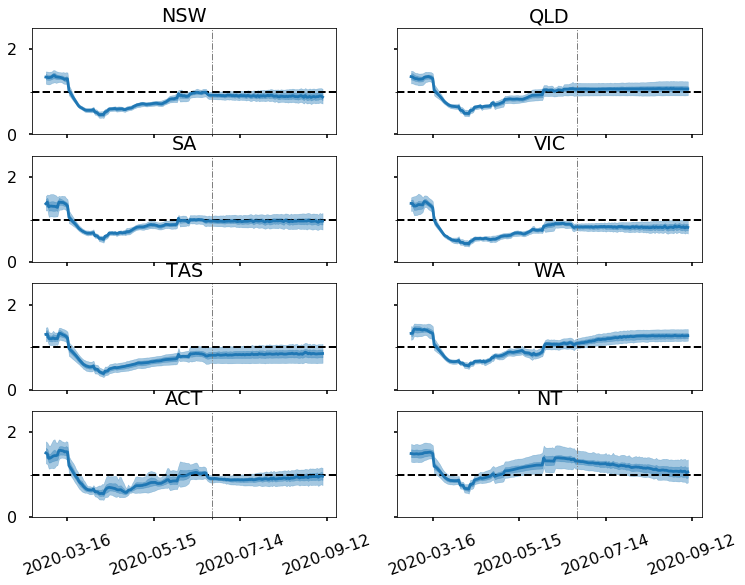

In [11]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='R_L')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,2,3],minor=False)
    ax[row,col].set_yticklabels([0,2,3],minor=False)
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,2.5))
    
    ax[row,col].set_xticks([plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
#fig.autofmt_xdate()
plt.savefig("../figs/soc_mob_R_L_hats.pdf")    
plt.show()

In [12]:
df_Rhats = df_Rhats[['state','date','type','median','bottom','lower','upper','top']+[i+mob_samples*i for i in range(mob_samples)]
                    #+[3*i+mob_samples*i for i in range(mob_samples)]
                   ]
df_Rhats.columns = ['state','date','type','median','bottom','lower','upper','top'] + [i for i in range(100)]
df_Rhats

,state,date,type,median,bottom,lower,upper,top,0,1,...,90,91,92,93,94,95,96,97,98,99
0,ACT,2020-03-01,R_I,0.098086,0.076025,0.091164,0.108846,0.118991,0.079295,0.095699,...,0.082565,0.118078,0.087081,0.089213,0.102486,0.098107,0.096938,0.108531,0.107920,0.110484
1,ACT,2020-03-01,R_I,0.098086,0.076025,0.091164,0.108846,0.118991,0.079295,0.095699,...,0.082565,0.118078,0.087081,0.089213,0.102486,0.098107,0.096938,0.108531,0.107920,0.110484
2,ACT,2020-03-01,R_L,1.512969,1.268205,1.405803,1.633867,1.786012,1.407007,1.256914,...,1.814414,1.433797,1.468489,1.659301,1.482863,1.227592,1.632925,1.710333,1.555535,1.729174
3,ACT,2020-03-01,R_L0,1.512969,1.268205,1.405803,1.633867,1.786012,1.407007,1.256914,...,1.814414,1.433797,1.468489,1.659301,1.482863,1.227592,1.632925,1.710333,1.555535,1.729174
4,ACT,2020-03-02,R_I,0.098086,0.076025,0.091164,0.108846,0.118991,0.079295,0.095699,...,0.082565,0.118078,0.087081,0.089213,0.102486,0.098107,0.096938,0.108531,0.107920,0.110484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6943,WA,2020-09-08,R_L0,1.243848,1.061686,1.184913,1.347717,1.422945,1.229563,1.061805,...,1.460092,1.178095,1.191336,1.395854,1.187249,1.036654,1.326486,1.401561,1.248303,1.315125
6944,WA,2020-09-09,R_I,0.098086,0.076025,0.091164,0.108846,0.118991,0.079295,0.095699,...,0.082565,0.118078,0.087081,0.089213,0.102486,0.098107,0.096938,0.108531,0.107920,0.110484
6945,WA,2020-09-09,R_I,0.098086,0.076025,0.091164,0.108846,0.118991,0.079295,0.095699,...,0.082565,0.118078,0.087081,0.089213,0.102486,0.098107,0.096938,0.108531,0.107920,0.110484
6946,WA,2020-09-09,R_L,1.270128,1.150827,1.210235,1.332525,1.426353,1.258695,1.270765,...,1.467496,1.150873,1.357409,1.220131,1.351298,1.160881,1.380396,1.226824,1.205443,1.162703


In [13]:
from datetime import datetime
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')

#df_Rhats.to_csv('./soc_mob_R'+today+'.csv')
df_Rhats.to_hdf('../data/soc_mob_R'+today+'.h5',key='Reff')


//anaconda3/lib/python3.7/site-packages/pandas/io/pytables.py:282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
//anaconda3/lib/python3.7/site-packages/pandas/io/pytables.py:282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_items] [items->None]

  f(store)


In [17]:
df_Rhats.loc[df_Rhats.state=='NT'].head(20)
display(d.loc[('VIC')].head(40))

,,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
date,type,,,,,,,,,,,,,,,,,,,,,
2020-03-01,R_L,2.226117,1.999202,2.298268,1.940207,2.177900,1.998405,2.376381,2.010491,2.084179,1.998354,...,2.168599,2.215366,1.955967,1.882867,2.321299,2.197079,2.039537,2.390135,1.835034,2.040480
2020-03-02,R_L,2.242050,2.044374,2.357916,1.962285,2.206088,2.017725,2.403727,2.031362,2.115776,2.043621,...,2.217376,2.231581,1.971082,1.912794,2.349411,2.200772,2.085071,2.408641,1.858484,2.043990
2020-03-03,R_L,2.295474,2.266727,2.672647,2.024149,2.323215,2.115462,2.423825,2.163233,2.152753,2.315459,...,2.250157,2.211468,2.066164,2.025857,2.298196,2.211501,2.282586,2.361086,2.004274,2.138315
2020-03-04,R_L,2.295242,2.281505,2.689480,2.029468,2.327800,2.125129,2.426096,2.169299,2.159291,2.331759,...,2.260499,2.213124,2.077054,2.038308,2.302062,2.214396,2.300485,2.364470,2.013821,2.140780
2020-03-05,R_L,2.283900,2.304811,2.735715,2.036796,2.337751,2.139327,2.432357,2.178186,2.178815,2.353938,...,2.308699,2.199127,2.075976,2.052321,2.318466,2.206059,2.310236,2.352089,2.026723,2.125506
2020-03-06,R_L,2.284224,2.370676,2.855863,2.068747,2.381513,2.195945,2.467191,2.224541,2.227748,2.427640,...,2.406908,2.206374,2.103836,2.103751,2.369992,2.219591,2.363347,2.363624,2.068268,2.125908
2020-03-07,R_L,2.262543,2.344628,2.801887,2.051325,2.348733,2.177088,2.439439,2.195494,2.208836,2.395744,...,2.378622,2.188601,2.098452,2.089713,2.348176,2.208864,2.346108,2.349902,2.052780,2.111103
2020-03-08,R_L,2.232075,2.295653,2.725267,2.027021,2.305259,2.173837,2.399407,2.171659,2.171069,2.350703,...,2.320054,2.177125,2.109573,2.074415,2.319379,2.220998,2.317875,2.344028,2.031971,2.112832
2020-03-09,R_L,2.176730,2.223413,2.609016,1.986023,2.233041,2.165647,2.328566,2.130397,2.110576,2.283427,...,2.229710,2.145304,2.123833,2.050025,2.265612,2.230709,2.273709,2.320297,2.002000,2.108740


# Interpretation
Exmaine what macro and micro distancing means in regards to baseline and current values.

In [14]:
# Plot logistic function over time

ban = '2020-03-20'
for state in states:
#sort df_R by date so that rows are dates
    df_state = df_R.loc[df_R.state==state]
    
    
    post_values = samples[predictors].values.T
    dd = df_state.date
    
    df1 =df_state.loc[df_state.date<=ban]
    df2 = df_state.loc[df_state.date>ban]
    X1 = df1[predictors]/100 #N by K
    X2 = df2[predictors]/100
    logodds = X1 @ post_values # N by K times (Nsamples by K )^T = N by N
    md = samples['md'].values.copy()
    
    #logodds = df_state.loc[df_state.date<='2020-03-15',predictors].values/100 @ samples[predictors].values.T #row is a date, column is a posterior sample
    md[:logodds.shape[0]] = 1
    
    logodds = np.append(logodds,X2 @ post_values,axis=0)
                        #df_state.loc[df_state.date>'2020-03-15',predictors].values/100 @ samples[predictors].values.T, axis = 0)
    factor = 2* md* expit( logodds ) 
    
    
    factor_lower = np.percentile(factor,25,axis=1)
    factor_upper = np.percentile(factor,75,axis=1)
    
    factor_bottom = np.percentile(factor,5,axis=1)
    factor_top = np.percentile(factor,95,axis=1)

    
    factor_med = np.median(factor,axis=1)
    
    #factor
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['factor']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(factor_lower)
    state_Rs['median'].extend(factor_med)
    state_Rs['upper'].extend(factor_upper)
    state_Rs['top'].extend(factor_top)
    state_Rs['bottom'].extend(factor_bottom)
    state_Rs['mean'].extend(np.mean(factor,axis=1))
    state_Rs['std'].extend(np.std(factor,axis=1))
    
    #now do without microdistnacing
    no_md = 2*expit(logodds)
    factor = no_md
    factor_lower = np.percentile(factor,25,axis=1)
    factor_upper = np.percentile(factor,75,axis=1)
    
    factor_bottom = np.percentile(factor,5,axis=1)
    factor_top = np.percentile(factor,95,axis=1)

    
    factor_med = np.median(factor,axis=1)
    
    #no md
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['no_md']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(factor_lower)
    state_Rs['median'].extend(factor_med)
    state_Rs['upper'].extend(factor_upper)
    state_Rs['top'].extend(factor_top)
    state_Rs['bottom'].extend(factor_bottom)
    state_Rs['mean'].extend(np.mean(factor,axis=1))
    state_Rs['std'].extend(np.std(factor,axis=1))

    
df_Rhats = pd.DataFrame().from_dict(state_Rs)

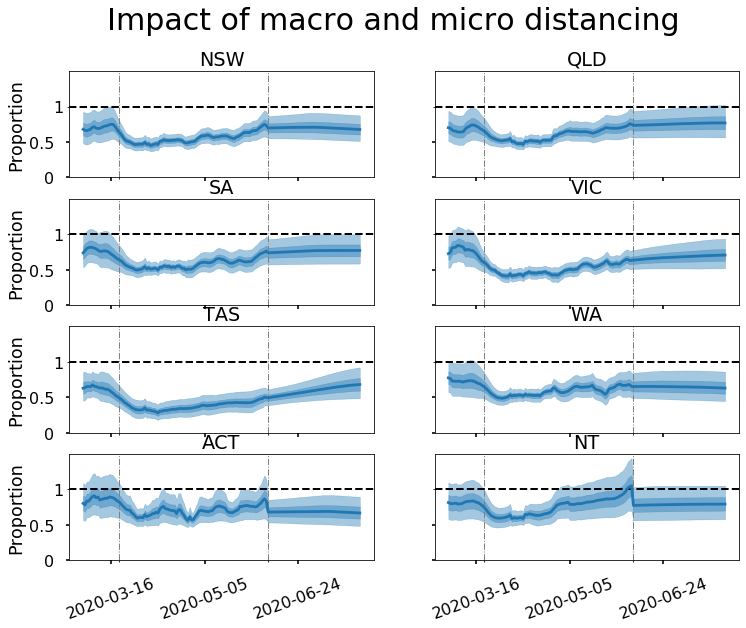

In [15]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='factor')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,0.5],minor=False)
    ax[row,col].set_yticklabels([0,0.5],minor=False)
    ax[row,col].set_yticklabels([1],minor=True)
    
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,1.5))
    
    ax[row,col].set_xticks([ban,plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
    
    if col==0:
        ax[row,col].set_ylabel('Proportion')
    
#fig.autofmt_xdate()
fig.suptitle("Impact of macro and micro distancing", fontsize=30)
plt.savefig("./figs/distance_impact.pdf")    
plt.show()

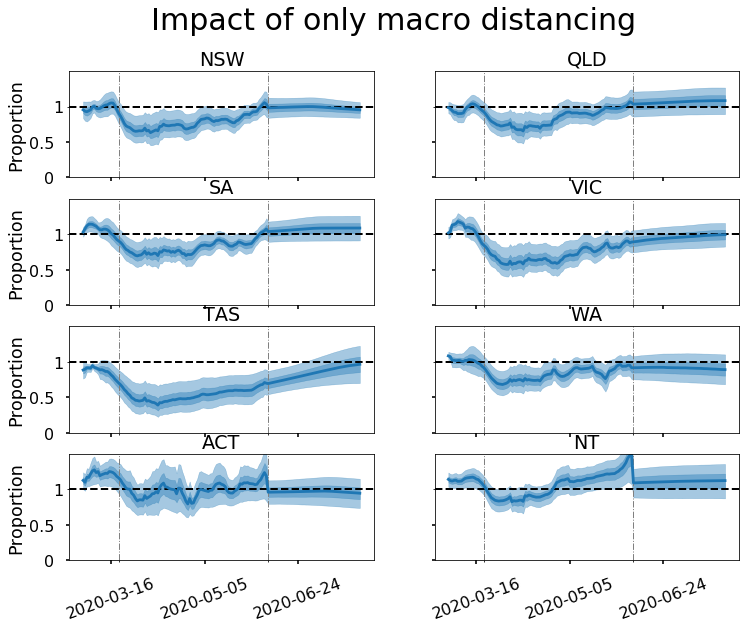

In [16]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='no_md')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,0.5],minor=False)
    ax[row,col].set_yticklabels([0,0.5],minor=False)
    ax[row,col].set_yticklabels([1],minor=True)
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,1.5))
    
    ax[row,col].set_xticks([ban,plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
    if col==0:
        ax[row,col].set_ylabel('Proportion')
#fig.autofmt_xdate()
fig.suptitle("Impact of only macro distancing", fontsize=30)
plt.savefig("./figs/macro.pdf")    
plt.show()

## Effect of distancing on $R_L$

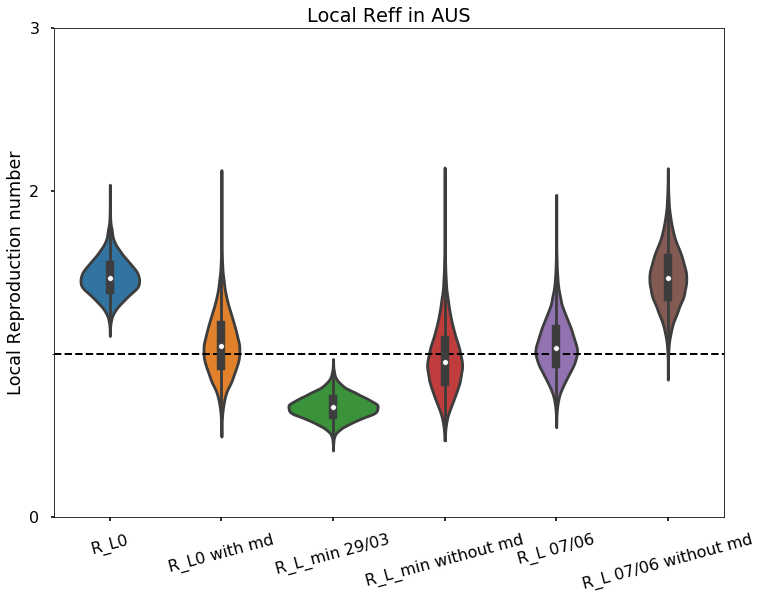

In [17]:
import seaborn as sns
df_samples['R_L0'] = samples.R_L
df_samples['R_L0 with md'] = samples.R_L * samples.md

##take lowest point in NSW data
min_row = df_Rhats.loc[(df_Rhats.state=='AUS') & 
                       (df_Rhats.type=='factor'),'mean'].values.argmin()

min_date= df_Rhats.iloc[min_row].date #29th March
X = df_R.loc[(df_R.date==min_date)&(df_R.state=='AUS'),predictors].values/100 #predictors
    
post_values = samples[predictors].values.T #K by 1000

min_RL = 2*samples.R_L.values*samples.md.values*expit(X @ post_values) # 1 by K times K 1000
min_RL_nomd = 2*samples.R_L.values*expit(X @ post_values) # 1 by K times K 1000
df_samples['R_L_min 29/03'] = min_RL.flatten()
df_samples['R_L_min without md'] = min_RL_nomd.flatten()

#Take last Google index, 21st May
last_date = df_google.date.values[-1]
last_date_str = pd.to_datetime(str(last_date)).strftime('%d/%m')
X = df_R.loc[(df_R.date==last_date)&(df_R.state=='AUS'),predictors].values/100 #predictors
    

post_values = samples[predictors].values.T #K by 1000

last_RL = 2*samples.R_L.values*samples.md.values*expit(X @ post_values) # 1 by K times K 1000
last_RL_nomd = 2*samples.R_L.values*expit(X @ post_values) # 1 by K times K 1000
df_samples['R_L '+last_date_str] = last_RL.flatten()
df_samples['R_L '+last_date_str+' without md'] = last_RL_nomd.flatten()

plot_df = pd.melt(df_samples[
    ['R_L0','R_L0 with md','R_L_min 29/03', 
     'R_L_min without md', 'R_L '+last_date_str,'R_L '+last_date_str+' without md']
])


fig,ax = plt.subplots(figsize=(12,9))
sns.violinplot(
        x='variable',
        y='value',
        data = plot_df,
        ax=ax,
    cut=0,
)
ax.set_title("Local Reff in AUS")
ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_ylabel('Local Reproduction number')
ax.set_xlabel('')
ax.tick_params('x', rotation=15)
ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.savefig('./figs/Local.pdf')
plt.show()

NSW
retail_and_recreation_7days    0.785147
grocery_and_pharmacy_7days     0.943081
parks_7days                    0.765646
transit_stations_7days         1.124297
workplaces_7days               1.033505
dtype: float64
VIC
retail_and_recreation_7days    0.770999
grocery_and_pharmacy_7days     0.905317
parks_7days                    0.736568
transit_stations_7days         1.142369
workplaces_7days               1.036765
dtype: float64
QLD
retail_and_recreation_7days    0.823989
grocery_and_pharmacy_7days     0.947991
parks_7days                    0.811257
transit_stations_7days         1.117864
workplaces_7days               1.026356
dtype: float64


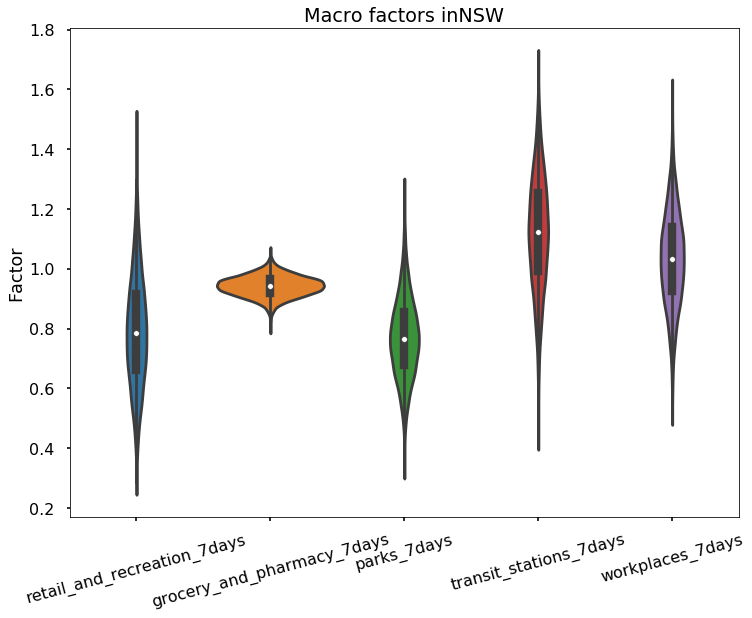

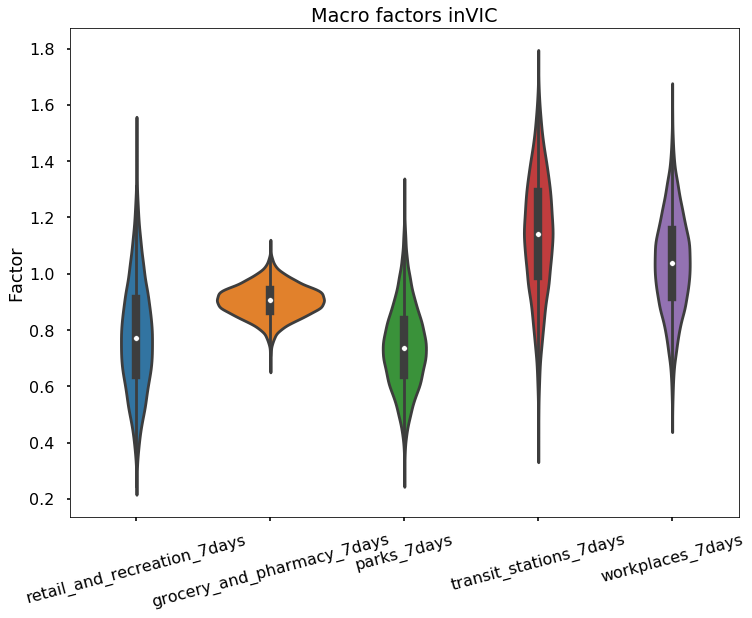

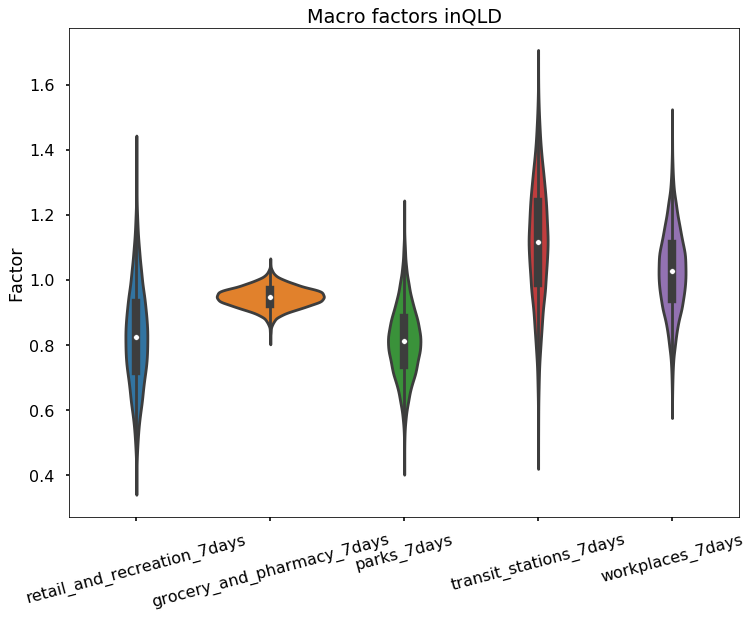

In [18]:
### Impact of individual parts
#Take last Google index, 21st May
for state in ['NSW','VIC','QLD']:
    single_pred = {}

    for i,pred in enumerate(predictors):
        X = df_R.loc[(df_R.date=='2020-03-29')&(df_R.state==state),pred].values/100 #predictors


        post_values = samples[pred].values.T #K by 1000


        last_RL_nomd = 2*expit(X * post_values) # 1 by K times K 1000
        single_pred[pred]= last_RL_nomd.flatten()

    plot_df = pd.melt(pd.DataFrame.from_dict(single_pred))
    print(state)
    print(pd.DataFrame.from_dict(single_pred).median())
    fig,ax = plt.subplots(figsize=(12,9))
    sns.violinplot(
            x='variable',
            y='value',
            data = plot_df,
            ax=ax,
        cut=1,
    )

    ax.set_title("Macro factors in" +state)
    ax.set_yticks([1],minor=True,)
    #ax.set_yticks([0,2,3],minor=False)
    ax.set_ylabel('Factor')
    ax.set_xlabel('')
    ax.tick_params('x', rotation=15)
    ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.show()

In [308]:
df_R.loc[df_R.date=='2020-03-23']

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days,policy
755,2020-05-23,AUS,-24.571429,-0.285714,-24.571429,-45.857143,-20.428571,1
754,2020-05-23,TAS,-30.857143,-13.142857,-55.142857,-48.714286,-15.000000,1
753,2020-05-23,ACT,-26.285714,-1.428571,7.285714,-43.142857,-23.000000,1
752,2020-05-23,SA,-19.285714,4.714286,-20.571429,-35.428571,-12.142857,1
751,2020-05-23,VIC,-31.000000,-2.857143,-24.714286,-56.142857,-28.142857,1
750,2020-05-23,QLD,-19.000000,2.000000,-10.428571,-44.714286,-15.000000,1
749,2020-05-23,NSW,-25.857143,-0.571429,-29.285714,-44.714286,-22.142857,1
748,2020-05-23,WA,-19.857143,1.428571,-38.714286,-45.285714,-12.285714,1
747,2020-05-23,NT,-3.000000,20.571429,11.571429,-27.714286,6.000000,1


In [40]:
min_RL = 2*df_samples.md.values*expit(X @ post_values) # 1 by K times K 1000
2*df_samples.md.values*expit(X @ post_values)

array([[0.40029017, 0.55652395, 0.44423486, ..., 0.32070831, 0.31617324,
        0.30867425]])

In [42]:
min_RL = 2*df_samples.md.values*expit(X @ post_values)

In [44]:
min_RL.shape

(1, 10000)